# Imports and Color Set

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import cpi
import tol_colors as tc
import numpy as np
from matplotlib.patches import Patch
import seaborn as sns

In [3]:
plt.figure(figsize=(13,13))
plt.rcParams['font.family'] = 'Helvetica'
plt.rcParams['font.size'] = 20
plt.rcParams['axes.labelsize'] = 25
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['figure.titlesize'] = 20
cset = tc.tol_cset('bright')

<Figure size 936x936 with 0 Axes>

In [3]:
cset

bri_cset(blue='#4477AA', red='#EE6677', green='#228833', yellow='#CCBB44', cyan='#66CCEE', purple='#AA3377', grey='#BBBBBB', black='#000000')

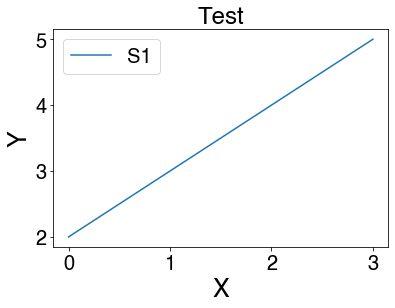

In [4]:
plt.plot([0,1,2,3],[2,3,4,5],label='S1')
plt.title('Test')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()

# Descriptive - Generation, Revenue, Customers

## Importing and merging EIA form 861 data

In [5]:
#Iterate over EIA 861 tables from 2014-2022
yrs = list(range(2014,2023))
yr_dfs=[]
for yr in yrs:
    #Load in a file
    file = 'Sales_Ult_Cust_'+str(yr)+'.xlsx'
    df=pd.read_excel('EIA Data/'+file,sheet_name="States",header=2)
    
    #Keep only California IOUs, MOUs, CCAs
    df=df[((df['Ownership']=='Community Choice Aggregator') | (df['Ownership']=='Municipal') | (df['Ownership']=='Political Subdivision') |(df['Ownership']=='Investor Owned') |  (df['Utility Name']=='Southern California Edison Co')) & (df['State']=='CA')]
    
    #Rename ownership to abbreviation
    df['Ownership'] = df['Ownership'].map({'Investor Owned': 'IOU',
                                           'Community Choice Aggregator': 'CCA',
                                           'Municipal':'POU',
                                           'Political Subdivision':'POU'
                                          })

    
    #Only keep useful columns, and make them integers
    df=df[['Data Year', 'Utility Name','Service Type','Ownership','Thousand Dollars.1','Megawatthours.1','Count.1','Thousand Dollars.2','Megawatthours.2','Count.2','Thousand Dollars','Megawatthours','Count']]
    cols = ['Thousand Dollars.1','Megawatthours.1','Count.1','Thousand Dollars.2','Megawatthours.2','Count.2','Thousand Dollars','Megawatthours','Count']
    df[cols] = df[cols].apply(pd.to_numeric, errors='coerce', axis=1).fillna(0)
    
    #Rename columns to make sense
    df=df.rename(columns={"Data Year": "Year", 
                          "Thousand Dollars": "Revenue (thousand$)_res",'Megawatthours':'Sales (MWh)_res','Count':'Customers_res',
                         "Thousand Dollars.1": "Revenue (thousand$)_com",'Megawatthours.1':'Sales (MWh)_com','Count.1':'Customers_com',
                         "Thousand Dollars.2": "Revenue (thousand$)_ind",'Megawatthours.2':'Sales (MWh)_ind','Count.2':'Customers_ind'})
    
    #Ensure everything is in integer form
    df.astype({"Revenue (thousand$)_res":'int32','Sales (MWh)_res':'int32','Customers_res':'int32',
                          "Revenue (thousand$)_com":'int32','Sales (MWh)_com':'int32','Customers_com':'int32',
                          "Revenue (thousand$)_com":'int32','Sales (MWh)_com':'int32','Customers_ind':'int32'})
    
    
    
    #Keep only 3 chosen utilities
    df['Utility Name'] = df['Utility Name'].str.replace('.', '',regex=False)
    df=df[(df['Utility Name']=='Southern California Edison Co')|(df['Utility Name']=='Pacific Gas & Electric Co')|(df['Utility Name']=='San Diego Gas & Electric Co')
         | (df['Utility Name']=='Los Angeles Department of Water & Power')|(df['Utility Name']=='Sacramento Municipal Util Dist')|(df['Utility Name']=='Imperial Irrigation District')
         |(df['Utility Name']=='Marin Clean Energy')|(df['Utility Name']=='East Bay Community Energy')|(df['Utility Name']=='Clean Power Alliance of Southern Califor')]    
    
    df.reset_index(drop=True,inplace=True)
    yr_dfs.append(df)

#Merge all EIA into a single form and output to CSV
all_eia = pd.concat(yr_dfs)
all_eia.to_csv("Merged EIA data.csv")

## Consolidating cust, revenue, sales data for top 3 IOUs, POUs, CCAs

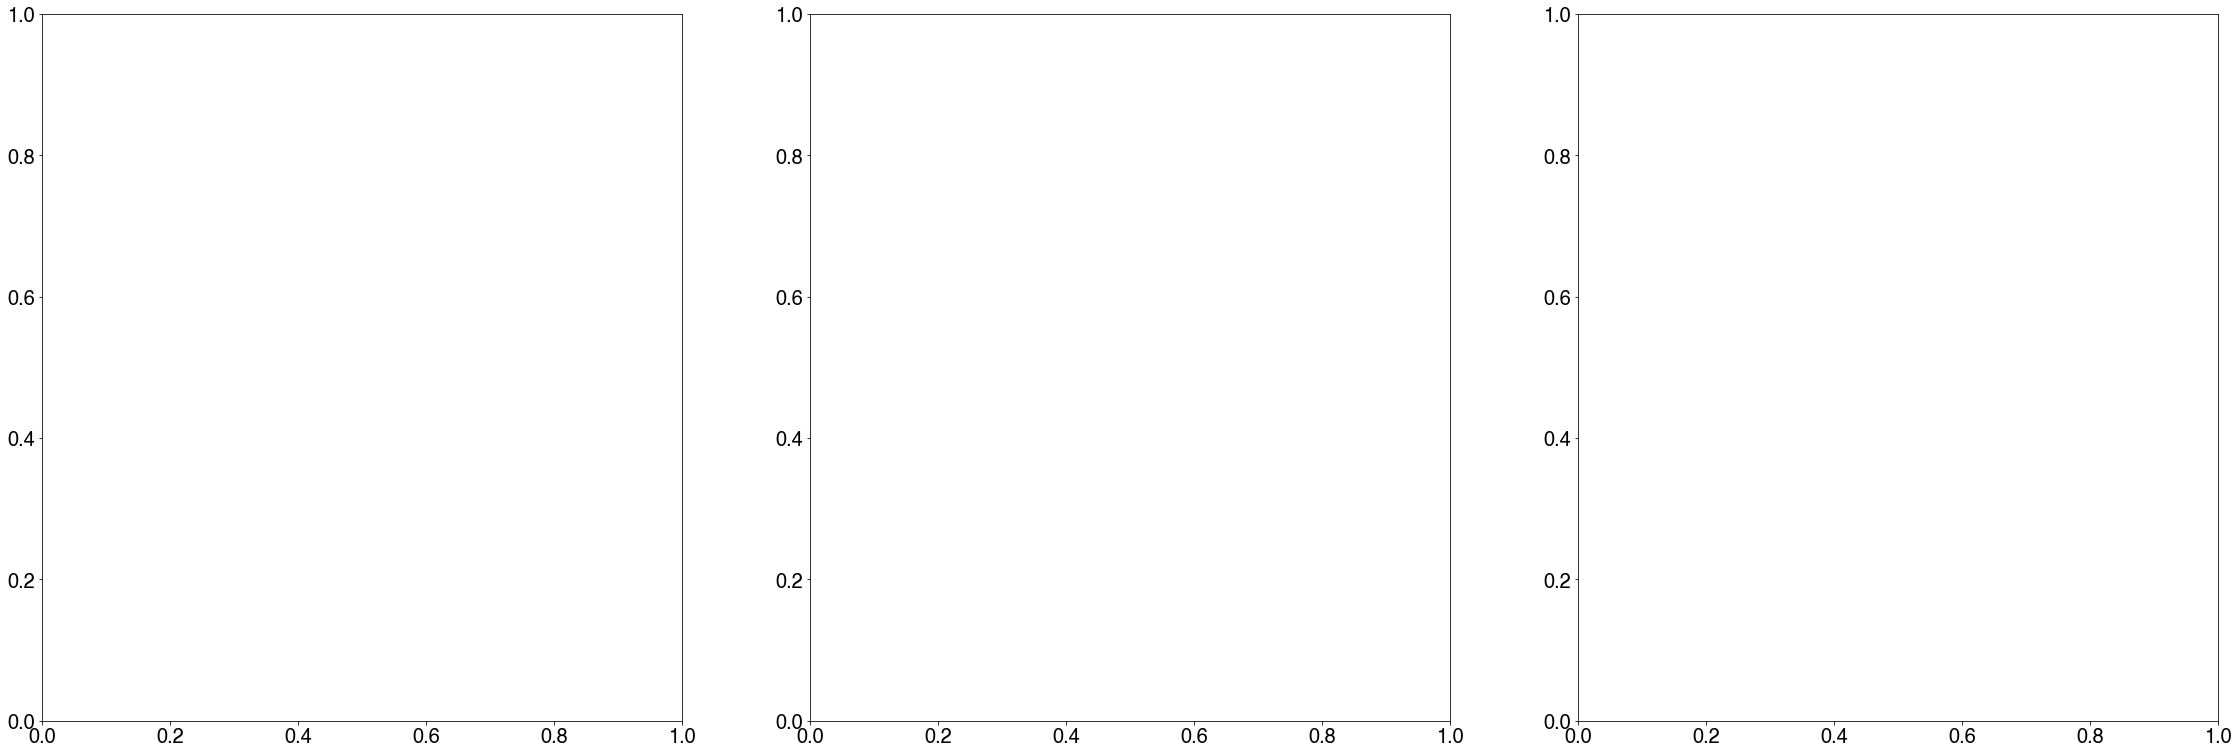

In [19]:
fig,axs = plt.subplots(nrows=1,ncols=3,figsize=(39,13))

In [20]:
#Slice to just data from 2022
latest_year = all_eia[all_eia['Year']==2022].copy()

#Sort
latest_year.sort_values(by=['Customers_res'],inplace=True)
latest_year.sort_values(by=['Ownership'],inplace=True)

#GRAPHING HELPERS

#Make an array of x values for the bar chart x-axis
def string_to_integer_mapping(strings):
    seen = {}
    result = []
    for string in strings:
        if string not in seen:
            seen[string] = len(seen)
        result.append(seen[string])
    return result
x_vals = np.array(string_to_integer_mapping(latest_year['Utility Name']))


#New columns - base height and column color for each type
latest_year['BaseHeight_res']=0
latest_year['BaseHeight_com']=0
latest_year['BaseHeight_ind']=0

latest_year['Color_res']='#4477AA'
latest_year['Color_com']='#EE6677'
latest_year['Color_ind']='#BBBBBB'

#Iterate over each row in the table, and where we have a delivery-only row, give it a "bottom" height, so that it gets stacked on top of the "bundled" bar
for index, row in latest_year.iterrows():   
    if row['Service Type']=='Delivery':
        latest_year.at[index,'Color_res']='#66CCEE'
        latest_year.at[index,'BaseHeight_res'] = latest_year[(latest_year['Utility Name']==row['Utility Name'])&(latest_year['Service Type']=='Bundled')]['Customers_res'].item()
        
        latest_year.at[index,'Color_com']='#AA3377'
        latest_year.at[index,'BaseHeight_com'] = latest_year[(latest_year['Utility Name']==row['Utility Name'])&(latest_year['Service Type']=='Bundled')]['Customers_com'].item()
        
        latest_year.at[index,'Color_ind']='#000000'
        latest_year.at[index,'BaseHeight_ind'] = latest_year[(latest_year['Utility Name']==row['Utility Name'])&(latest_year['Service Type']=='Bundled')]['Customers_ind'].item()
        
#Cleanup names to just include uppercase characters
for index, row in latest_year.iterrows():
    base_string = row['Utility Name'].replace('Authority','').replace('.','')
    no_co = base_string[:-2] if base_string.endswith("Co") else base_string
    latest_year.at[index,'Utility Name'] = ''.join([c for c in no_co if ((c.isupper())|(c=='&'))])

#Begin plotting
#plt.figure(figsize=(13,13))
#width=0.25
axs[0].bar(x_vals,height=latest_year['Customers_res']/1e6,bottom=latest_year['BaseHeight_res']/1e6,color=latest_year['Color_res'])#,width=width)
#plt.bar(x_vals,height=latest_year['Customers_com'],bottom=latest_year['BaseHeight_com'],color=latest_year['Color_com'],width=width)
#plt.bar(x_vals+width,height=latest_year['Customers_ind'],bottom=latest_year['BaseHeight_ind'],color=latest_year['Color_ind'],width=width)

#plt.yscale("log")
axs[0].set_xticks(ticks=np.arange(len(latest_year['Utility Name'].unique())),
           labels=latest_year['Utility Name'].unique(),
           rotation=90)
axs[0].set_title('Number of Customers (millions)')
#Add vertical lines to separate different types of utilities

#Helper function that finds transitions between ownership types
temp_newdf_forlines = latest_year.drop_duplicates(subset='Utility Name', keep="last")
def find_transition_indices(lst):
    transition_indices = []
    for i in range(1, len(lst)):
        if lst[i] != lst[i - 1]:
            transition_indices.append(i - 1)
    return np.array(transition_indices)
lst = temp_newdf_forlines['Ownership'].to_list()
result = find_transition_indices(lst)
axs[0].vlines(x=result+0.5,ymin=0,ymax=1e7,linestyles='dotted',linewidth=5,color='k')
axs[0].set_ylim([0,5])
axs[0].set_xlabel('Utility Name')
axs[0].set_ylabel('Number of Customers (millions)')

#Construct legend

legend_elements = [Patch(facecolor='#4477AA', edgecolor='#4477AA',label='Residential'),
                   Patch(facecolor='#66CCEE', edgecolor='#66CCEE',label='Residential\nDeliveryOnly'),
                   #Patch(facecolor='#EE6677', edgecolor='#EE6677',label='Commercial'),
                   ##Patch(facecolor='#AA3377', edgecolor='#AA3377',label='Commercial\nDeliveryOnly'),
                   #Patch(facecolor='#BBBBBB', edgecolor='#BBBBBB',label='Industrial'),
                   #Patch(facecolor='#000000', edgecolor='#000000',label='Industrial\nDeliveryOnly')
                  ]

#axs[0].legend(handles=legend_elements,loc='upper right',bbox_to_anchor=(1.3,1))

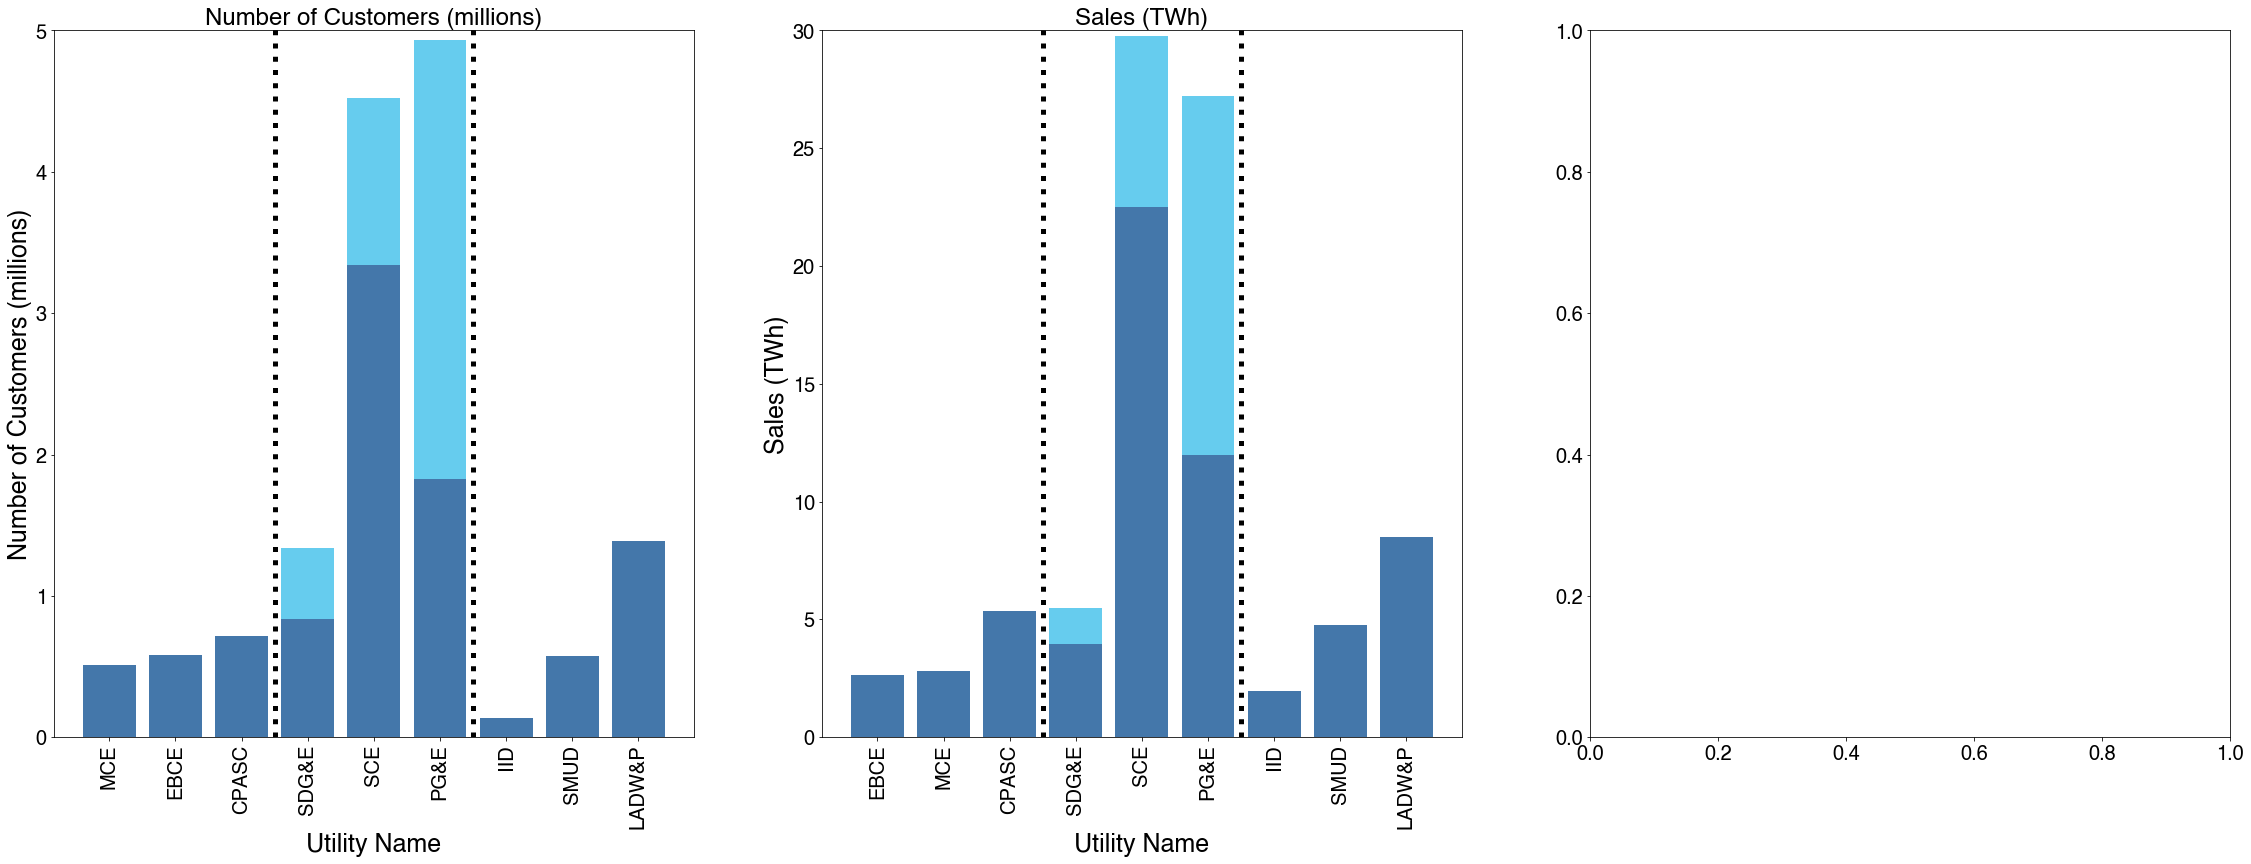

In [21]:
#Slice to just data from 2022
latest_year = all_eia[all_eia['Year']==2022].copy()

#Sort
latest_year.sort_values(by=['Sales (MWh)_res'],inplace=True)
latest_year.sort_values(by=['Ownership'],inplace=True)

#GRAPHING HELPERS

#Make an array of x values for the bar chart x-axis
def string_to_integer_mapping(strings):
    seen = {}
    result = []
    for string in strings:
        if string not in seen:
            seen[string] = len(seen)
        result.append(seen[string])
    return result
x_vals = np.array(string_to_integer_mapping(latest_year['Utility Name']))


#New columns - base height and column color for each type
latest_year['BaseHeight_res']=0
latest_year['BaseHeight_com']=0
latest_year['BaseHeight_ind']=0

latest_year['Color_res']='#4477AA'
latest_year['Color_com']='#EE6677'
latest_year['Color_ind']='#BBBBBB'

#Iterate over each row in the table, and where we have a delivery-only row, give it a "bottom" height, so that it gets stacked on top of the "bundled" bar
for index, row in latest_year.iterrows():   
    if row['Service Type']=='Delivery':
        latest_year.at[index,'Color_res']='#66CCEE'
        latest_year.at[index,'BaseHeight_res'] = latest_year[(latest_year['Utility Name']==row['Utility Name'])&(latest_year['Service Type']=='Bundled')]['Sales (MWh)_res'].item()
        
        latest_year.at[index,'Color_com']='#AA3377'
        latest_year.at[index,'BaseHeight_com'] = latest_year[(latest_year['Utility Name']==row['Utility Name'])&(latest_year['Service Type']=='Bundled')]['Sales (MWh)_com'].item()
        
        latest_year.at[index,'Color_ind']='#000000'
        latest_year.at[index,'BaseHeight_ind'] = latest_year[(latest_year['Utility Name']==row['Utility Name'])&(latest_year['Service Type']=='Bundled')]['Sales (MWh)_ind'].item()
        
#Cleanup names to just include uppercase characters
for index, row in latest_year.iterrows():
    base_string = row['Utility Name'].replace('Authority','').replace('.','')
    no_co = base_string[:-2] if base_string.endswith("Co") else base_string
    latest_year.at[index,'Utility Name'] = ''.join([c for c in no_co if ((c.isupper())|(c=='&'))])

#Begin plotting
#plt.figure(figsize=(13,13))
#width=0.25
axs[1].bar(x_vals,height=latest_year['Sales (MWh)_res']/1e6,bottom=latest_year['BaseHeight_res']/1e6,color=latest_year['Color_res'])#,width=width)
#plt.bar(x_vals,height=latest_year['Sales (MWh)_com'],bottom=latest_year['BaseHeight_com'],color=latest_year['Color_com'],width=width)
#plt.bar(x_vals+width,height=latest_year['Sales (MWh)_ind'],bottom=latest_year['BaseHeight_ind'],color=latest_year['Color_ind'],width=width)

#plt.yscale("log")
axs[1].set_xticks(ticks=np.arange(len(latest_year['Utility Name'].unique())),
           labels=latest_year['Utility Name'].unique(),
           rotation=90)
axs[1].set_title('Sales (TWh)')

#Add vertical lines to separate different types of utilities

#Helper function that finds transitions between ownership types
temp_newdf_forlines = latest_year.drop_duplicates(subset='Utility Name', keep="last")
def find_transition_indices(lst):
    transition_indices = []
    for i in range(1, len(lst)):
        if lst[i] != lst[i - 1]:
            transition_indices.append(i - 1)
    return np.array(transition_indices)
lst = temp_newdf_forlines['Ownership'].to_list()
result = find_transition_indices(lst)

ymax=30
axs[1].vlines(x=result+0.5,ymin=0,ymax=ymax,linestyles='dotted',linewidth=5,color='k')
axs[1].set_ylim([0,ymax])
axs[1].set_xlabel('Utility Name')
axs[1].set_ylabel('Sales (TWh)')

#Construct legend

legend_elements = [Patch(facecolor='#4477AA', edgecolor='#4477AA',label='Residential'),
                   Patch(facecolor='#66CCEE', edgecolor='#66CCEE',label='Residential\nDeliveryOnly'),
                   #Patch(facecolor='#EE6677', edgecolor='#EE6677',label='Commercial'),
                   #Patch(facecolor='#AA3377', edgecolor='#AA3377',label='Commercial\nDeliveryOnly'),
                   #Patch(facecolor='#BBBBBB', edgecolor='#BBBBBB',label='Industrial'),
                   #Patch(facecolor='#000000', edgecolor='#000000',label='Industrial\nDeliveryOnly')
                  ]

#axs[1].legend(handles=legend_elements,loc='upper right',bbox_to_anchor=(1.3,1))
fig

In [22]:
#Slice to just data from 2022
latest_year = all_eia[all_eia['Year']==2022].copy()

#Sort
latest_year.sort_values(by=['Revenue (thousand$)_res'],inplace=True)
latest_year.sort_values(by=['Ownership'],inplace=True)

#GRAPHING HELPERS

#Make an array of x values for the bar chart x-axis
def string_to_integer_mapping(strings):
    seen = {}
    result = []
    for string in strings:
        if string not in seen:
            seen[string] = len(seen)
        result.append(seen[string])
    return result
x_vals = np.array(string_to_integer_mapping(latest_year['Utility Name']))


#New columns - base height and column color for each type
latest_year['BaseHeight_res']=0
latest_year['BaseHeight_com']=0
latest_year['BaseHeight_ind']=0

latest_year['Color_res']='#4477AA'
latest_year['Color_com']='#EE6677'
latest_year['Color_ind']='#BBBBBB'

#Iterate over each row in the table, and where we have a delivery-only row, give it a "bottom" height, so that it gets stacked on top of the "bundled" bar
for index, row in latest_year.iterrows():   
    if row['Service Type']=='Delivery':
        latest_year.at[index,'Color_res']='#66CCEE'
        latest_year.at[index,'BaseHeight_res'] = latest_year[(latest_year['Utility Name']==row['Utility Name'])&(latest_year['Service Type']=='Bundled')]['Revenue (thousand$)_res'].item()
        
        latest_year.at[index,'Color_com']='#AA3377'
        latest_year.at[index,'BaseHeight_com'] = latest_year[(latest_year['Utility Name']==row['Utility Name'])&(latest_year['Service Type']=='Bundled')]['Revenue (thousand$)_com'].item()
        
        latest_year.at[index,'Color_ind']='#000000'
        latest_year.at[index,'BaseHeight_ind'] = latest_year[(latest_year['Utility Name']==row['Utility Name'])&(latest_year['Service Type']=='Bundled')]['Revenue (thousand$)_ind'].item()
        
#Cleanup names to just include uppercase characters
for index, row in latest_year.iterrows():
    base_string = row['Utility Name'].replace('Authority','').replace('.','')
    no_co = base_string[:-2] if base_string.endswith("Co") else base_string
    latest_year.at[index,'Utility Name'] = ''.join([c for c in no_co if ((c.isupper())|(c=='&'))])

#Begin plotting
#plt.figure(figsize=(13,13))
#width=0.25
axs[2].bar(x_vals+0.5,height=latest_year['Revenue (thousand$)_res']/1e6,bottom=latest_year['BaseHeight_res']/1e6,color=latest_year['Color_res'])#,width=width)
#plt.bar(x_vals,height=latest_year['Revenue (thousand$)_com'],bottom=latest_year['BaseHeight_com'],color=latest_year['Color_com'],width=width)
#plt.bar(x_vals+width,height=latest_year['Revenue (thousand$)_ind'],bottom=latest_year['BaseHeight_ind'],color=latest_year['Color_ind'],width=width)

#plt.yscale("log")
axs[2].set_xticks(ticks=np.arange(len(latest_year['Utility Name'].unique())),
           labels=latest_year['Utility Name'].unique(),
           rotation=90)
axs[2].set_title('Revenue (billion 2022$)')

#Add vertical lines to separate different types of utilities

#Helper function that finds transitions between ownership types
temp_newdf_forlines = latest_year.drop_duplicates(subset='Utility Name', keep="last")
def find_transition_indices(lst):
    transition_indices = []
    for i in range(1, len(lst)):
        if lst[i] != lst[i - 1]:
            transition_indices.append(i - 1)
    return np.array(transition_indices)
lst = temp_newdf_forlines['Ownership'].to_list()
result = find_transition_indices(lst)

ymax=7
axs[2].vlines(x=result+0.5,ymin=0,ymax=ymax,linestyles='dotted',linewidth=5,color='k')
axs[2].set_ylim([0,ymax])
axs[2].set_xlabel('Utility Name')
axs[2].set_ylabel('Revenue (billion 2022$)')

#Construct legend

legend_elements = [Patch(facecolor='#4477AA', edgecolor='#4477AA',label='Residential'),
                   Patch(facecolor='#66CCEE', edgecolor='#66CCEE',label='Residential\nDeliveryOnly'),
                   #Patch(facecolor='#EE6677', edgecolor='#EE6677',label='Commercial'),
                   ##Patch(facecolor='#AA3377', edgecolor='#AA3377',label='Commercial\nDeliveryOnly'),
                   #Patch(facecolor='#BBBBBB', edgecolor='#BBBBBB',label='Industrial'),
                   #Patch(facecolor='#000000', edgecolor='#000000',label='Industrial\nDeliveryOnly')
                  ]

axs[2].legend(handles=legend_elements,loc='upper right',bbox_to_anchor=(1.3,1))
fig.savefig('2022 snapshot of top 3 utilities.png',dpi=600,bbox_inches='tight')

/var/folders/h0/rfb20rk90qz0tdgv08kqcyrw0000gn/T/ipykernel_12133/3280145264.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1494073.3' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  latest_year.at[index,'BaseHeight_res'] = latest_year[(latest_year['Utility Name']==row['Utility Name'])&(latest_year['Service Type']=='Bundled')]['Revenue (thousand$)_res'].item()
/var/folders/h0/rfb20rk90qz0tdgv08kqcyrw0000gn/T/ipykernel_12133/3280145264.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '784580.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  latest_year.at[index,'BaseHeight_com'] = latest_year[(latest_year['Utility Name']==row['Utility Name'])&(latest_year['Service Type']=='Bundled')]['Revenue (thousand$)_com'].item()
/var/folders/h0/r

## Time series of POU, IOU bundled customers vs. CCA energy customers

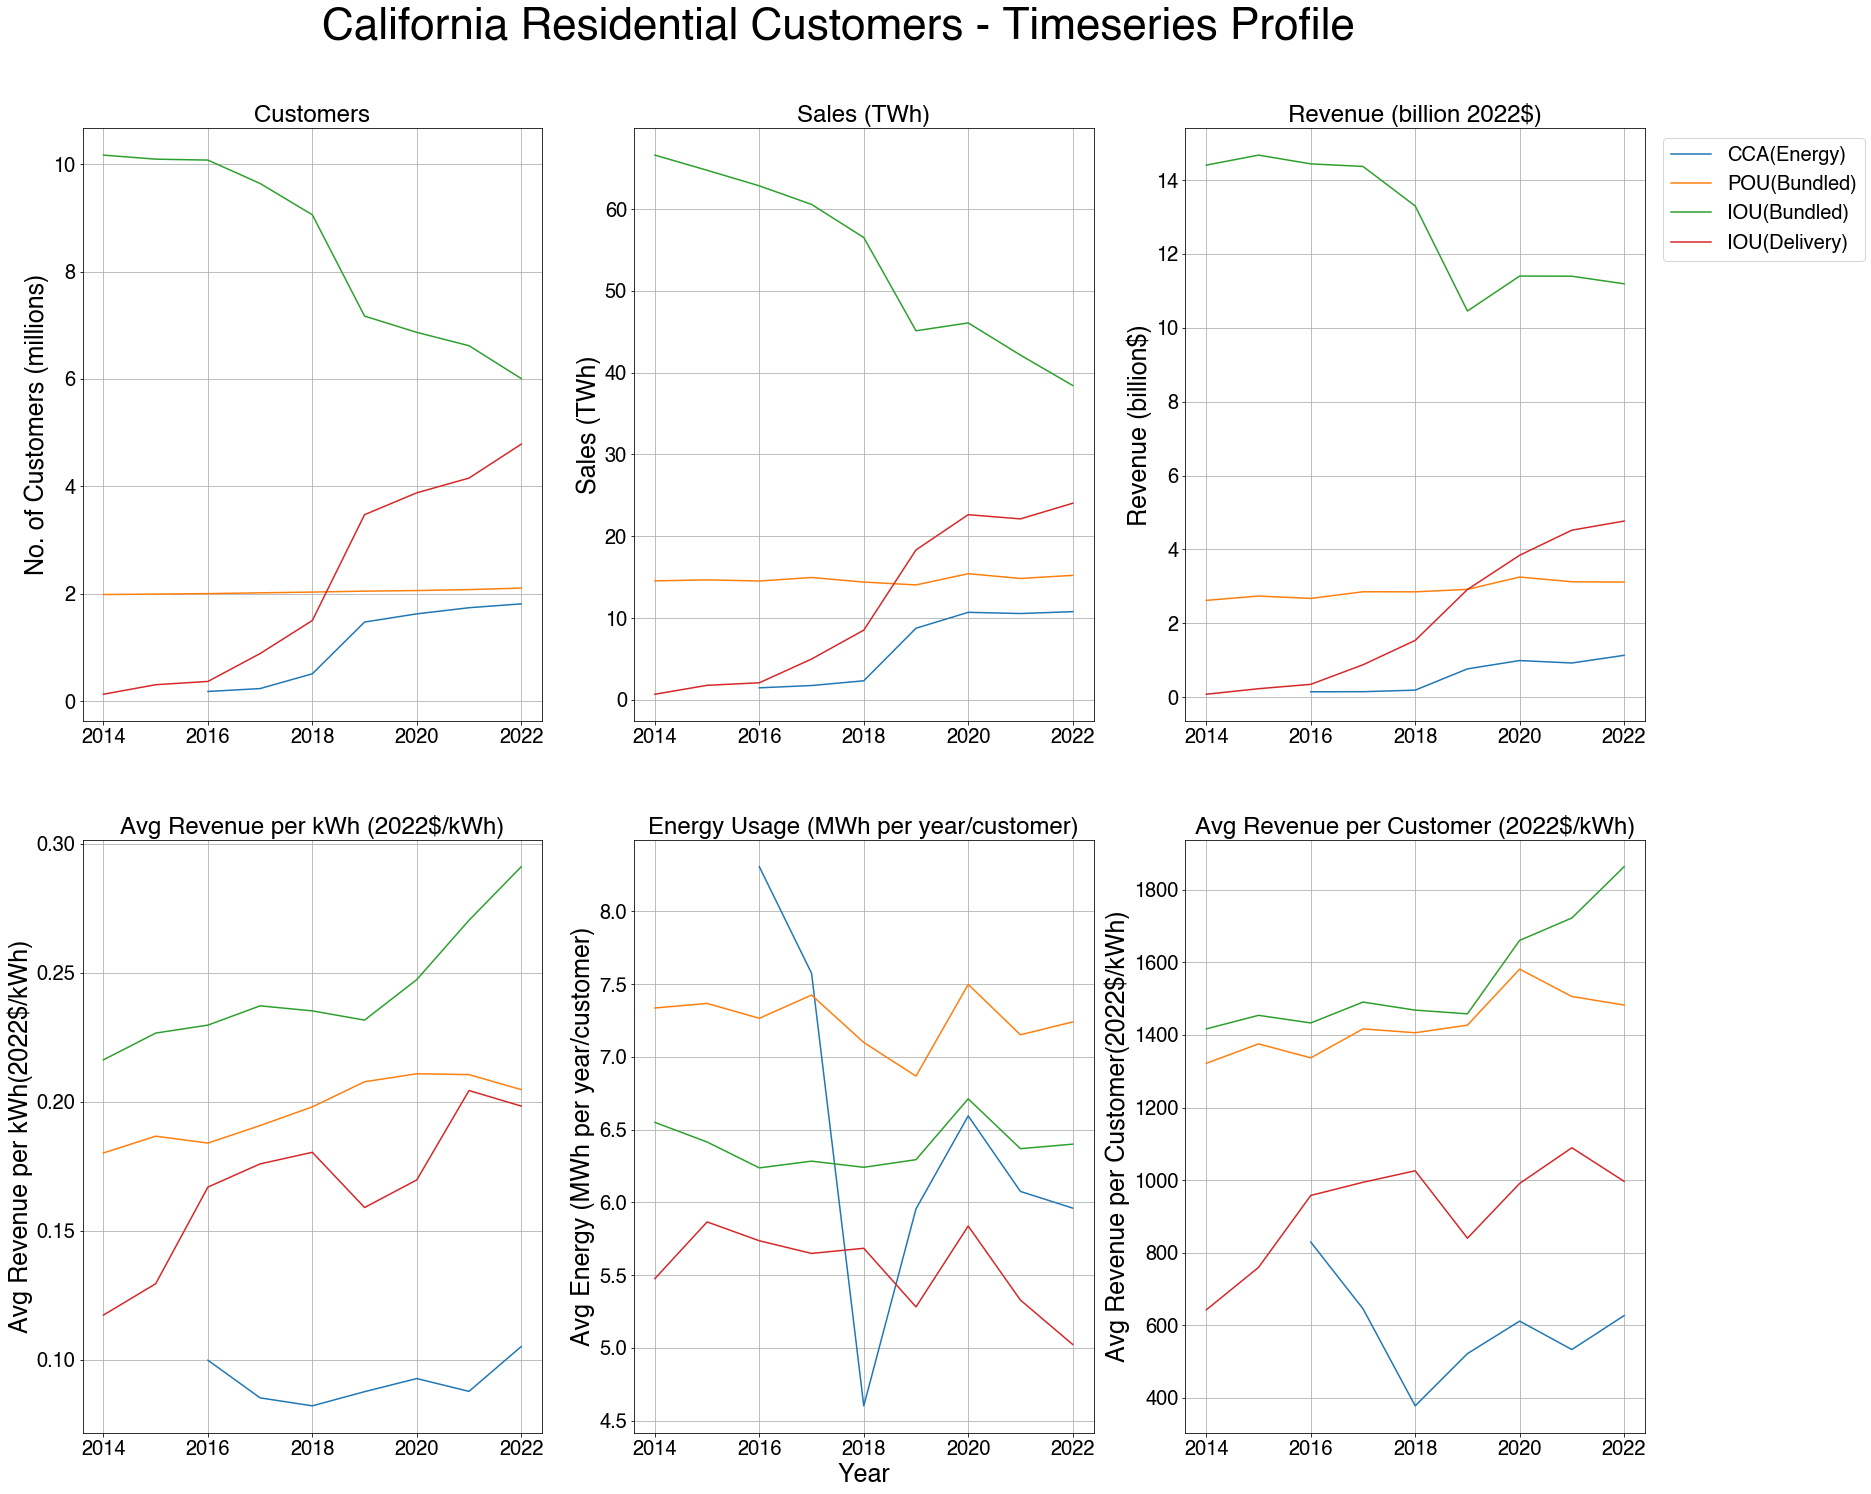

In [40]:
grouped_eia = all_eia.groupby(['Ownership','Service Type','Year']).agg('sum').reset_index(drop=False)
grouped_eia["real_Revenue (thousand$)_res"] = grouped_eia.apply(
    lambda x: cpi.inflate(x['Revenue (thousand$)_res'], x['Year']), axis=1
)

cca_energy = grouped_eia[grouped_eia['Ownership']=='CCA']
pou_bundled = grouped_eia[grouped_eia['Ownership']=='POU']
iou_bundled = grouped_eia[(grouped_eia['Ownership']=='IOU')&(grouped_eia['Service Type']=='Bundled')]
iou_delivery = grouped_eia[(grouped_eia['Ownership']=='IOU')&(grouped_eia['Service Type']=='Delivery')]


fig, axs = plt.subplots(nrows=2,ncols=3,figsize=(28,24))
for ax in axs.flatten():
    ax.grid(visible=True)

axs[0,0].plot(cca_energy['Year'],cca_energy['Customers_res']/1e6,label='CCA(Energy)')
axs[0,0].plot(pou_bundled['Year'],pou_bundled['Customers_res']/1e6,label='POU(Bundled)')
axs[0,0].plot(iou_bundled['Year'],iou_bundled['Customers_res']/1e6,label='IOU(Bundled)')
axs[0,0].plot(iou_delivery['Year'],iou_delivery['Customers_res']/1e6,label='IOU(Delivery)')

axs[0,0].legend(loc='upper right',bbox_to_anchor=(3.9,1))
#axs[0,0].set_xlabel('Year')

axs[0,0].set_ylabel('No. of Customers (millions)')
axs[0,0].set_title('Customers')


axs[0,1].plot(cca_energy['Year'],cca_energy['Sales (MWh)_res']/1e6,label='CCA(Energy)')
axs[0,1].plot(pou_bundled['Year'],pou_bundled['Sales (MWh)_res']/1e6,label='POU(Bundled)')
axs[0,1].plot(iou_bundled['Year'],iou_bundled['Sales (MWh)_res']/1e6,label='IOU(Bundled)')
axs[0,1].plot(iou_delivery['Year'],iou_delivery['Sales (MWh)_res']/1e6,label='IOU(Delivery)')

#axs[0,0].legend(loc='upper right',bbox_to_anchor=(1.7,1))
#axs[1,0].set_xlabel('Year')
axs[0,1].set_ylabel('Sales (TWh)')
axs[0,1].set_title('Sales (TWh)')


axs[0,2].plot(cca_energy['Year'],cca_energy['real_Revenue (thousand$)_res']/1e6,label='CCA(Energy)')
axs[0,2].plot(pou_bundled['Year'],pou_bundled['real_Revenue (thousand$)_res']/1e6,label='POU(Bundled)')
axs[0,2].plot(iou_bundled['Year'],iou_bundled['real_Revenue (thousand$)_res']/1e6,label='IOU(Bundled)')
axs[0,2].plot(iou_delivery['Year'],iou_delivery['real_Revenue (thousand$)_res']/1e6,label='IOU(Delivery)')

#axs[0,0].legend(loc='upper right',bbox_to_anchor=(1.7,1))
#axs[2,0].set_xlabel('Year')
axs[0,2].set_ylabel('Revenue (billion$)')
axs[0,2].set_title('Revenue (billion 2022$)')

axs[1,0].plot(cca_energy['Year'],(cca_energy['real_Revenue (thousand$)_res']/1e6)/(cca_energy['Sales (MWh)_res']/1e6),label='CCA(Energy)')
axs[1,0].plot(pou_bundled['Year'],(pou_bundled['real_Revenue (thousand$)_res']/1e6)/(pou_bundled['Sales (MWh)_res']/1e6),label='POU(Bundled)')
axs[1,0].plot(iou_bundled['Year'],(iou_bundled['real_Revenue (thousand$)_res']/1e6)/(iou_bundled['Sales (MWh)_res']/1e6),label='IOU(Bundled)')
axs[1,0].plot(iou_delivery['Year'],(iou_delivery['real_Revenue (thousand$)_res']/1e6)/(iou_delivery['Sales (MWh)_res']/1e6),label='IOU(Delivery)')

#axs[0,0].legend(loc='upper right',bbox_to_anchor=(1.7,1))
#axs[2,0].set_xlabel('Year')
axs[1,0].set_ylabel('Avg Revenue per kWh(2022$/kWh)')
axs[1,0].set_title('Avg Revenue per kWh (2022$/kWh)')

axs[1,1].plot(cca_energy['Year'],cca_energy['Sales (MWh)_res']/cca_energy['Customers_res'],label='CCA(Energy)')
axs[1,1].plot(pou_bundled['Year'],pou_bundled['Sales (MWh)_res']/pou_bundled['Customers_res'],label='POU(Bundled)')
axs[1,1].plot(iou_bundled['Year'],iou_bundled['Sales (MWh)_res']/iou_bundled['Customers_res'],label='IOU(Bundled)')
axs[1,1].plot(iou_delivery['Year'],iou_delivery['Sales (MWh)_res']/iou_delivery['Customers_res'],label='IOU(Delivery)')

#axs[0,0].legend(loc='upper right',bbox_to_anchor=(1.7,1))
#axs[2,0].set_xlabel('Year')
axs[1,1].set_ylabel('Avg Energy (MWh per year/customer)')
axs[1,1].set_title('Energy Usage (MWh per year/customer)')

axs[1,2].plot(cca_energy['Year'],1e3*cca_energy['real_Revenue (thousand$)_res']/cca_energy['Customers_res'],label='CCA(Energy)')
axs[1,2].plot(pou_bundled['Year'],1e3*pou_bundled['real_Revenue (thousand$)_res']/pou_bundled['Customers_res'],label='POU(Bundled)')
axs[1,2].plot(iou_bundled['Year'],1e3*iou_bundled['real_Revenue (thousand$)_res']/iou_bundled['Customers_res'],label='IOU(Bundled)')
axs[1,2].plot(iou_delivery['Year'],1e3*iou_delivery['real_Revenue (thousand$)_res']/iou_delivery['Customers_res'],label='IOU(Delivery)')

#axs[0,0].legend(loc='upper right',bbox_to_anchor=(1.7,1))
#axs[2,0].set_xlabel('Year')
axs[1,2].set_ylabel('Avg Revenue per Customer(2022$/kWh)')
axs[1,2].set_title('Avg Revenue per Customer (2022$/kWh)')


fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)
plt.xlabel("Year")
#plt.ylabel("common Y")
plt.suptitle("California Residential Customers - Timeseries Profile",fontsize=44,y=0.95)

fig.savefig('Res only - Timeseries of all parameters.png',dpi=600,bbox_inches='tight')

In [ ]:
grouped_eia = all_eia.groupby(['Ownership','Service Type','Year']).agg('sum').reset_index(drop=False)
grouped_eia["real_Revenue (thousand$)_res"] = grouped_eia.apply(
    lambda x: cpi.inflate(x['Revenue (thousand$)_res'], x['Year']), axis=1
)
grouped_eia["real_Revenue (thousand$)_com"] = grouped_eia.apply(
    lambda x: cpi.inflate(x['Revenue (thousand$)_com'], x['Year']), axis=1
)
grouped_eia["real_Revenue (thousand$)_ind"] = grouped_eia.apply(
    lambda x: cpi.inflate(x['Revenue (thousand$)_ind'], x['Year']), axis=1
)


cca_energy = grouped_eia[grouped_eia['Ownership']=='CCA']
pou_bundled = grouped_eia[grouped_eia['Ownership']=='POU']
iou_bundled = grouped_eia[(grouped_eia['Ownership']=='IOU')&(grouped_eia['Service Type']=='Bundled')]

fig, axs = plt.subplots(nrows=4,ncols=3,figsize=(28,24))
for ax in axs.flatten():
    ax.grid(visible=True)

axs[0,0].plot(cca_energy['Year'],cca_energy['Customers_res']/1e6,label='CCA(Energy)')
axs[0,0].plot(pou_bundled['Year'],pou_bundled['Customers_res']/1e6,label='POU(Bundled)')
axs[0,0].plot(iou_bundled['Year'],iou_bundled['Customers_res']/1e6,label='IOU(Bundled)')
axs[0,0].legend(loc='upper right',bbox_to_anchor=(3.9,1))
#axs[0,0].set_xlabel('Year')

axs[0,0].set_ylabel('No. of Customers (millions)')
axs[0,0].set_title('Residential Customers')

axs[0,1].plot(cca_energy['Year'],cca_energy['Customers_com']/1e6,label='CCA(Energy)')
axs[0,1].plot(pou_bundled['Year'],pou_bundled['Customers_com']/1e6,label='POU(Bundled)')
axs[0,1].plot(iou_bundled['Year'],iou_bundled['Customers_com']/1e6,label='IOU(Bundled)')
#axs[0,0].legend(loc='upper right',bbox_to_anchor=(1.7,1))
#axs[0,1].set_xlabel('Year')
#axs[0,1].set_ylabel('No. of Customers')
axs[0,1].set_title('Commercial Customers')

axs[0,2].plot(cca_energy['Year'],cca_energy['Customers_ind']/1e6,label='CCA(Energy)')
axs[0,2].plot(pou_bundled['Year'],pou_bundled['Customers_ind']/1e6,label='POU(Bundled)')
axs[0,2].plot(iou_bundled['Year'],iou_bundled['Customers_ind']/1e6,label='IOU(Bundled)')
#axs[0,0].legend(loc='upper right',bbox_to_anchor=(1.7,1))
#axs[0,2].set_xlabel('Year')
#axs[0,2].set_ylabel('No. of Customers')
axs[0,2].set_title('Industrial Customers')


axs[1,0].plot(cca_energy['Year'],cca_energy['Sales (MWh)_res']/1e6,label='CCA(Energy)')
axs[1,0].plot(pou_bundled['Year'],pou_bundled['Sales (MWh)_res']/1e6,label='POU(Bundled)')
axs[1,0].plot(iou_bundled['Year'],iou_bundled['Sales (MWh)_res']/1e6,label='IOU(Bundled)')
#axs[0,0].legend(loc='upper right',bbox_to_anchor=(1.7,1))
#axs[1,0].set_xlabel('Year')
axs[1,0].set_ylabel('Sales (TWh)')
axs[1,0].set_title('Residential Sales (TWh)')

axs[1,1].plot(cca_energy['Year'],cca_energy['Sales (MWh)_com']/1e6,label='CCA(Energy)')
axs[1,1].plot(pou_bundled['Year'],pou_bundled['Sales (MWh)_com']/1e6,label='POU(Bundled)')
axs[1,1].plot(iou_bundled['Year'],iou_bundled['Sales (MWh)_com']/1e6,label='IOU(Bundled)')
#axs[0,0].legend(loc='upper right',bbox_to_anchor=(1.7,1))
#axs[1,1].set_xlabel('Year')
#axs[1,1].set_ylabel('Sales (MWh)')
axs[1,1].set_title('Commercial Sales (TWh)')

axs[1,2].plot(cca_energy['Year'],cca_energy['Sales (MWh)_ind']/1e6,label='CCA(Energy)')
axs[1,2].plot(pou_bundled['Year'],pou_bundled['Sales (MWh)_ind']/1e6,label='POU(Bundled)')
axs[1,2].plot(iou_bundled['Year'],iou_bundled['Sales (MWh)_ind']/1e6,label='IOU(Bundled)')
#axs[0,0].legend(loc='upper right',bbox_to_anchor=(1.7,1))
#axs[1,2].set_xlabel('Year')
#axs[1,2].set_ylabel('Sales (MWh)')
axs[1,2].set_title('Industrial Sales (TWh)')


axs[2,0].plot(cca_energy['Year'],cca_energy['real_Revenue (thousand$)_res']/1e6,label='CCA(Energy)')
axs[2,0].plot(pou_bundled['Year'],pou_bundled['real_Revenue (thousand$)_res']/1e6,label='POU(Bundled)')
axs[2,0].plot(iou_bundled['Year'],iou_bundled['real_Revenue (thousand$)_res']/1e6,label='IOU(Bundled)')
#axs[0,0].legend(loc='upper right',bbox_to_anchor=(1.7,1))
#axs[2,0].set_xlabel('Year')
axs[2,0].set_ylabel('Revenue (billion$)')
axs[2,0].set_title('Residential Revenue (billion 2022$)')

axs[2,1].plot(cca_energy['Year'],cca_energy['real_Revenue (thousand$)_com']/1e6,label='CCA(Energy)')
axs[2,1].plot(pou_bundled['Year'],pou_bundled['real_Revenue (thousand$)_com']/1e6,label='POU(Bundled)')
axs[2,1].plot(iou_bundled['Year'],iou_bundled['real_Revenue (thousand$)_com']/1e6,label='IOU(Bundled)')
#axs[0,0].legend(loc='upper right',bbox_to_anchor=(1.7,1))
#axs[2,1].set_xlabel('Year')
#axs[2,1].set_ylabel('Revenue (thousand$)')
axs[2,1].set_title('Commercial Revenue (billion 2022$)')

axs[2,2].plot(cca_energy['Year'],cca_energy['real_Revenue (thousand$)_ind']/1e6,label='CCA(Energy)')
axs[2,2].plot(pou_bundled['Year'],pou_bundled['real_Revenue (thousand$)_ind']/1e6,label='POU(Bundled)')
axs[2,2].plot(iou_bundled['Year'],iou_bundled['real_Revenue (thousand$)_ind']/1e6,label='IOU(Bundled)')
#axs[0,0].legend(loc='upper right',bbox_to_anchor=(1.7,1))
#axs[2,2].set_xlabel('Year')
#axs[2,2].set_ylabel('Revenue (thousand$)')
axs[2,2].set_title('Industrial Revenue (billion 2022$)')



axs[3,0].plot(cca_energy['Year'],(cca_energy['real_Revenue (thousand$)_res']/1e6)/(cca_energy['Sales (MWh)_res']/1e6),label='CCA(Energy)')
axs[3,0].plot(pou_bundled['Year'],(pou_bundled['real_Revenue (thousand$)_res']/1e6)/(pou_bundled['Sales (MWh)_res']/1e6),label='POU(Bundled)')
axs[3,0].plot(iou_bundled['Year'],(iou_bundled['real_Revenue (thousand$)_res']/1e6)/(iou_bundled['Sales (MWh)_res']/1e6),label='IOU(Bundled)')
#axs[0,0].legend(loc='upper right',bbox_to_anchor=(1.7,1))
#axs[2,0].set_xlabel('Year')
axs[3,0].set_ylabel('Avg Revenue (billion 2022$/TWh)')
axs[3,0].set_title('Residential Avg Revenue (billion 2022$/TWh)')

axs[3,1].plot(cca_energy['Year'],(cca_energy['real_Revenue (thousand$)_com']/1e6)/(cca_energy['Sales (MWh)_com']/1e6),label='CCA(Energy)')
axs[3,1].plot(pou_bundled['Year'],(pou_bundled['real_Revenue (thousand$)_com']/1e6)/(pou_bundled['Sales (MWh)_com']/1e6),label='POU(Bundled)')
axs[3,1].plot(iou_bundled['Year'],(iou_bundled['real_Revenue (thousand$)_com']/1e6)/(iou_bundled['Sales (MWh)_com']/1e6),label='IOU(Bundled)')
#axs[0,0].legend(loc='upper right',bbox_to_anchor=(1.7,1))
#axs[2,1].set_xlabel('Year')
#axs[2,1].set_ylabel('Revenue (thousand$)')
axs[3,1].set_title('Commercial Avg Revenue (billion 2022$/TWh)')

axs[3,2].plot(cca_energy['Year'],(cca_energy['real_Revenue (thousand$)_ind']/1e6)/(cca_energy['Sales (MWh)_ind']/1e6),label='CCA(Energy)')
axs[3,2].plot(pou_bundled['Year'],(pou_bundled['real_Revenue (thousand$)_ind']/1e6)/(pou_bundled['Sales (MWh)_ind']/1e6),label='POU(Bundled)')
axs[3,2].plot(iou_bundled['Year'],(iou_bundled['real_Revenue (thousand$)_ind']/1e6)/(iou_bundled['Sales (MWh)_ind']/1e6),label='IOU(Bundled)')
#axs[0,0].legend(loc='upper right',bbox_to_anchor=(1.7,1))
#axs[2,2].set_xlabel('Year')
#axs[2,2].set_ylabel('Revenue (thousand$)')
axs[3,2].set_title('Industrial Avg Revenue (billion 2022$/TWh)')


fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)
plt.xlabel("Year")
#plt.ylabel("common Y")

fig.savefig('Timeseries of all parameters.png',dpi=600,bbox_inches='tight')

# FERC 1 data

In [2]:
data = pd.read_csv('FERC1_datafiles/dispositions_and_opex_and_transmission_and_sales_and_rev_and_tdplant.csv')
data.drop(labels='Unnamed: 0',axis='columns',inplace=True)
eia_ferc = pd.read_csv('FERC1_datafiles/eia ferc fuzzy matched manually corrected.csv').dropna(subset='eia')

eia_codes = pd.read_csv('FERC1_datafiles/utilities_entity_eia.csv')


merged_eia_codes = pd.merge(eia_ferc,
        eia_codes,
        left_on='eia',
        right_on='utility_name_eia',
        how='left')

ferc_codes = pd.read_csv('FERC1_datafiles/utilities_ferc1.csv')


merged_ferc_codes = pd.merge(merged_eia_codes,
                            ferc_codes,
                            left_on='ferc',
                            right_on='utility_name_ferc1',
                            how='right')[['utility_id_eia',
                                         'utility_id_ferc1',
                                         'utility_name_ferc1',
                                         'utility_name_eia']]
states = pd.read_csv('FERC1_datafiles/utilities_eia860.csv',usecols=[0,2,5])
states['year_dt'] = pd.to_datetime(states['report_date']).dt.year
nerc = pd.read_excel('FERC1_datafiles/StateCodesNERC.xlsx')
merged_eia_interconn_regions = pd.merge(nerc,states,how='right',left_on='Code',right_on='state')[['NERC','State','Code','utility_id_eia']]
ferc_subset_with_nercregion = pd.merge(merged_eia_interconn_regions,
        merged_ferc_codes,
        how='right',
        on='utility_id_eia').dropna(subset='NERC').drop_duplicates()
nerc_interconn_subset_data_disagg = pd.merge(ferc_subset_with_nercregion,
        data,
        how='inner',
        left_on=['utility_id_ferc1'],
        right_on=['utility_id_ferc1'])
nerc_interconn_subset_data_disagg.to_csv('FERC1_datafiles/FERC1 data with EIA merge subset and NERC regions.csv')

pge_sum = nerc_interconn_subset_data_disagg[nerc_interconn_subset_data_disagg['utility_name_ferc1_x']=='PACIFIC GAS AND ELECTRIC COMPANY'].groupby('report_year').sum().reset_index()
sce_sum = nerc_interconn_subset_data_disagg[nerc_interconn_subset_data_disagg['utility_name_ferc1_x']=='Southern California Edison Company'].groupby('report_year').sum().reset_index()
sdge_sum = nerc_interconn_subset_data_disagg[nerc_interconn_subset_data_disagg['utility_name_ferc1_x']=='San Diego Gas & Electric Company'].groupby('report_year').sum().reset_index()

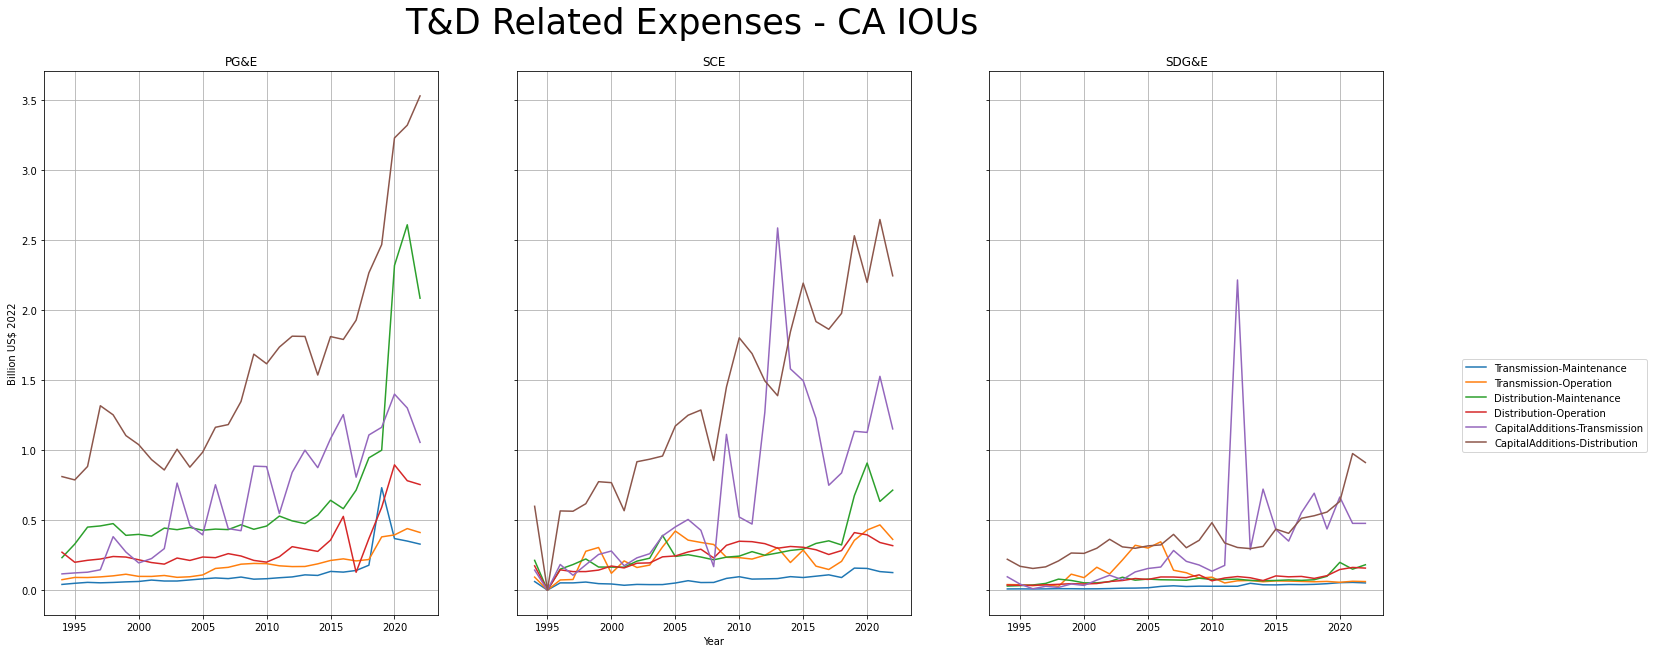

In [3]:
dfs = [pge_sum,sce_sum,sdge_sum]
names = ['PG&E','SCE','SDG&E']

fig,axs = plt.subplots(nrows=1,ncols=3,figsize=(24,10),sharey=True)

for idx,df in enumerate(dfs):
    df['year_dt']=pd.to_datetime(df.report_year, format='%Y')
    #inflate key columns
    inflate_cols = ['distribution_maintenance_expense_electric','distribution_operation_expenses_electric',
                   'transmission_maintenance_expense_electric','transmission_operation_expense',
                   'additions_transmission_plant','additions_distribution_plant',
                   'injuries_and_damages']
    for col in inflate_cols:
        df['real_'+col] = df.apply(lambda x: cpi.inflate(x[col], x["year_dt"],to=pd.to_datetime(2022,format="%Y")),axis=1)
    axs[idx].plot(df['report_year'],df['real_transmission_maintenance_expense_electric']/1e9,label='Transmission-Maintenance')
    axs[idx].plot(df['report_year'],df['real_transmission_operation_expense']/1e9,label='Transmission-Operation')
    axs[idx].plot(df['report_year'],df['real_distribution_maintenance_expense_electric']/1e9,label='Distribution-Maintenance')
    axs[idx].plot(df['report_year'],df['real_distribution_operation_expenses_electric']/1e9,label='Distribution-Operation')
    axs[idx].plot(df['report_year'],df['real_additions_transmission_plant']/1e9,label='CapitalAdditions-Transmission')
    axs[idx].plot(df['report_year'],df['real_additions_distribution_plant']/1e9,label='CapitalAdditions-Distribution')
    #axs[idx].plot(df['report_year'],df['real_injuries_and_damages']/1e9,label='Wildfire-Injuries + Damages')
    axs[idx].grid(visible=True)
    axs[idx].set_title(names[idx])
    

plt.legend(loc=(1.2,0.3))

fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)
plt.xlabel("Year")
plt.ylabel("Billion US$ 2022")
plt.suptitle("T&D Related Expenses - CA IOUs",fontsize=35,y=0.97)
plt.savefig("T&D Related Expenses - CA IOUs.png",dpi=600,bbox_inches='tight')

In [9]:
merge3 = pd.concat(dfs)

clean_df = merge3[['report_year','utility_name_eia',
                'real_injuries_and_damages',
    'real_transmission_maintenance_expense_electric',
    'real_transmission_operation_expense',
    'real_distribution_maintenance_expense_electric',
    'real_distribution_operation_expenses_electric',
   'real_additions_transmission_plant',
   'real_additions_distribution_plant']]    

clean_df.rename(columns={
    'report_year':'Year',
    'utility_name_eia':'Utility Name',
    'real_injuries_and_damages':'Injuries & Damages (2022$)',
    'real_transmission_maintenance_expense_electric':'Transmission Maintenance Expenses (2022$)',
    'real_transmission_operation_expense':'Transmission Operation Expenses (2022$)',
    'real_distribution_maintenance_expense_electric':'Distribution Maintenance Expenses (2022$)',
    'real_distribution_operation_expenses_electric':'Distribution Operation Expenses (2022$)',
    'real_additions_transmission_plant':'Transmission Plant Capital Additions (2022$)',
    'real_additions_distribution_plant':'Distribution Plant Capital Additions (2022$)'
},inplace=True)
clean_df.to_csv('Clean FERC1 data for 3 CA IOUs.csv')

/var/folders/h0/rfb20rk90qz0tdgv08kqcyrw0000gn/T/ipykernel_30968/1016553234.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df.rename(columns={


# Plotting rates

In [3]:
tiered = pd.read_excel('Consolidated Rate Info -.xlsx',sheet_name='New-Tiered',nrows=18,usecols='A:F')
tou = pd.read_excel('Consolidated Rate Info v3.xlsx',sheet_name='TOU',nrows=18,usecols='A:F')
tou_ev = pd.read_excel('Consolidated Rate Info v3.xlsx',sheet_name='TOU-EV',nrows=18,usecols='A:F')

FileNotFoundError: [Errno 2] No such file or directory: 'Consolidated Rate Info v3.xlsx'

In [ ]:
tiered = pd.read_excel('Consolidated Rate Info -.xlsx',sheet_name='New-Tiered',nrows=18,usecols='A:F')
tou = pd.read_excel('Consolidated Rate Info v3.xlsx',sheet_name='TOU',nrows=18,usecols='A:F')
tou_ev = pd.read_excel('Consolidated Rate Info v3.xlsx',sheet_name='TOU-EV',nrows=18,usecols='A:F')

fig,axs = plt.subplots(nrows=1,ncols=3,figsize=(20,8))
sns.stripplot(ax=axs[0],data=tiered,x='Tier',y='Energy ($/kWh)',hue='Type',jitter=0.1,s=8)
axs[0].set_title('Domestic Tiered Rate ($/kWh)')
axs[0].get_legend().remove()
sns.stripplot(ax=axs[1],data=tou,x='Peak Level',y='Rate',hue='Type',jitter=0.1,s=8)
axs[1].set_title('Default TOU Rate ($/kWh)')
axs[1].get_legend().remove()
sns.stripplot(ax=axs[2],data=tou_ev,x='Peak Level',y='Rate',hue='Type',jitter=0.1,s=8)
axs[2].set_title('Default TOU-EV Rate ($/kWh)')
plt.legend(bbox_to_anchor=(1, 0.9), bbox_transform=axs[2].transAxes)